Check the large scale galaxy bias as implied by the HOD models we use for each source and lens sample.

In [1]:
# Import modules
% matplotlib inline
import numpy as np; import scipy.integrate; import scipy.interpolate; import matplotlib.pyplot as plt
import pyccl as ccl; import shared_functions_wlp_wls as shared; import shared_functions_setup as setup
from halotools.empirical_models import PrebuiltHodModelFactory

/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/halo_table_cache.py:12: UserWarning: Some of the functionality of the HaloTableCache classrequires h5py to be installed.
  warn("Some of the functionality of the HaloTableCache class"
/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/user_supplied_ptcl_catalog.py:13: UserWarning: Most of the functionality of the sim_manager sub-package requires h5py to be installed,
which can be accomplished either with pip or conda
  warn("Most of the functionality of the sim_manager "
/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/download_manager.py:39: UserWarning: Some of the functionality of the DownloadManager requires h5py to be installed,
which can be accomplished either with pip or conda
  warn("Some of the functionality of the DownloadManager requires h5py to be installed,\n"
/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/cached_halo_catalog.py:15: UserWarning: Most of the functionality of the

In [14]:
# Set the survey
survey = 'SDSS'
if (survey == 'SDSS'):
    import params as pa
elif (survey == 'LSST_DESI'):
    import params_LSST_DESI as pa
    
# Also set whether we are looking at lenses or sources
gals = 'src'

In [15]:
#Initialize the cosmology
p = ccl.Parameters(Omega_c = pa.OmC, Omega_b = pa.OmB, h = (pa.HH0/100.), A_s = pa.A_s, n_s=pa.n_s_cosmo)
cosmo = ccl.Cosmology(p)

rho_crit = 3. * 10**10 * pa.mperMpc / (8. * np.pi * pa.Gnewt * pa.Msun)  # Msol h^2 / Mpc^3, for use with M in Msol / h (comoving distances)
rho_m = pa.OmM * rho_crit # units of Msol h^2 / Mpc^3 (comoving distances)

In [16]:
# Get the appropriate redshift distribution
if (gals=='lens'):
    z = np.linspace(pa.zLmin, pa.zLmax, 100)
    dNdz = setup.get_dNdzL(z, survey)
if (gals =='src'):
    z, dNdz_unnormed = setup.get_NofZ_unnormed(pa.dNdzpar_fid, pa.dNdztype, pa.zsmin, pa.zsmax, 500, survey)
    norm = scipy.integrate.simps(dNdz_unnormed, z)
    dNdz = dNdz_unnormed / norm

# Get the halo mass function and halo bias
Mhvec = np.logspace(5.9,16.5,30) # In units Msol / h
HMF = np.zeros((len(Mhvec), len(z)))
bh = np.zeros((len(Mhvec), len(z)))
for zi in range(0,len(z)):
    HMF[:,zi] = ccl.massfunction.massfunc(cosmo, Mhvec / (pa.HH0/100.), 1./ (1. + z[zi]), odelta=200.) / (pa.HH0/ 100.)**3
    bh[:,zi] = ccl.massfunction.halo_bias(cosmo, Mhvec / (pa.HH0/100.), 1./(1.+z[zi]), odelta=200.)
  
# Check normalization of halo bias
#norm = np.zeros(len(z))
#for zi in range(0,len(z)):
#    norm[zi]= scipy.integrate.simps(HMF[:, zi] * Mhvec / rho_m * bh[:, zi], np.log10(Mhvec / (pa.HH0 / 100.))) 

In [10]:
# Get y(k,M) (the fourier transformed profile)
logkmin = -6; kpts =40000; logkmax = 5; 
kvec_FT = np.logspace(logkmin, logkmax, kpts)
# Actually we will use a downsampled version of this:
k = np.logspace(np.log10(kvec_FT[0]), np.log10(kvec_FT[-1]), 40)
y = shared.gety(Mhvec, k, survey)


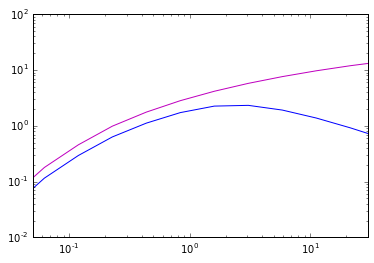

[  6.43887579e-01   6.43887579e-01   6.43887579e-01   6.43887579e-01
   6.43887579e-01   6.43887579e-01   6.43887578e-01   6.43887572e-01
   6.43887555e-01   6.43887502e-01   6.43887406e-01   6.43887312e-01
   6.43887087e-01   6.43886288e-01   6.43883431e-01   6.43872918e-01
   6.43834371e-01   6.43693165e-01   6.43176282e-01   6.41290924e-01
   6.34501100e-01   6.11134239e-01   5.41919448e-01   4.03505443e-01
   2.51572442e-01   1.42384982e-01   7.70523219e-02   4.10935433e-02
   2.19220924e-02   1.14694567e-02   5.73813280e-03   2.64316169e-03
   1.04849139e-03   3.49442171e-04   1.02523356e-04   2.44235422e-05
   4.52786570e-06   6.40882756e-07   6.99769100e-08   6.25618718e-09]


In [17]:
# Get the linear matter power spectrum from CCL to multiply through
Pklin = np.zeros((len(k), len(z)))
for zi in range(0,len(z)):
    Pklin[:, zi] = ccl.power.linear_matter_power(cosmo, k, 1. / (1. + z[zi]))

# We now have all the ingredients we require to get the 2-halo matter power spectrum 
# We don't use this, I'm just checking we get something reasonable at this intermediate step

twoh_fact = np.zeros((len(k), len(z)))
for ki in range(0,len(k)):
    for zi in range(0,len(z)):
        twoh_fact[ki, zi] = scipy.integrate.simps( Mhvec / rho_m * HMF[:,zi] * bh[:, zi] * y[ki, :], np.log10(Mhvec / (pa.HH0 / 100.)))    

Pk_2h = Pklin * (twoh_fact)**2

# Integrate over z
Pk_2h_avgz = np.zeros(len(k))
Pklin_avgz = np.zeros(len(k))
for ki in range(0,len(k)):
    Pk_2h_avgz[ki] = scipy.integrate.simps(dNdz * Pk_2h[ki,:], z)
    Pklin_avgz[ki] = scipy.integrate.simps(dNdz * Pklin[ki,:], z)

plt.figure()
plt.loglog(k, k**3 * Pk_2h_avgz / 2. / np.pi**2, 'b')
plt.hold(True)
plt.loglog(k, k**3 * Pklin_avgz  / 2. / np.pi**2, 'm')
plt.xlim(0.05,30)
plt.ylim(0.01, 100)
plt.show()

# This isn't exactly 1 at large scales because we aren't integrating down to all the masses where halos exist.
# This shouldn't matter in the end for galaxy bias because those mass halos won't host galaxies.
# When we get the galaxy bias we will compare to halofit ie the same as Pklin_avgz on large scales.
print Pk_2h_avgz / Pklin_avgz


In [18]:
# Now, we want to convert this to a 2-halo galaxy power spectrum using the various HOD's we use.

if (gals=='src'):
    # We need Mstarlow for the Zu & Mandelbaum halo model
    #tot_nsrc = shared.vol_dens(pa.fsky, pa.N_shapes, survey)
    #Mstarlow = shared.get_Mstar_low(survey, tot_nsrc)
    # Use halotools to get the occupations numbers fo Zu & Mandelbaum 2015. Use this as the sources for both cases.
    HOD = PrebuiltHodModelFactory('zu_mandelbaum15')

# Get occupation numbers as a function of mass
if (survey == 'SDSS'):
    if (gals=='lens'):
        HOD = PrebuiltHodModelFactory('zheng07', modulate_with_cenocc=True)
        HOD.param_dict['alpha'] = pa.alpha_reid
        HOD.param_dict['logM1'] = np.log10(pa.M1_reid)
        HOD.param_dict['logM0'] = np.log10(pa.Mcut_reid)
        HOD.param_dict['logMmin'] = np.log10(pa.Mmin_reid)
        HOD.param_dict['sigma_logM'] = pa.sigLogM_reid
        Ncen= HOD.mean_occupation_centrals(prim_haloprop = Mhvec/ (pa.HH0/100.))
        Nsat = HOD.mean_occupation_satellites(prim_haloprop = Mhvec/ (pa.HH0/100.))
        #Ncen = shared.get_Ncen_Reid(Mhvec, survey)  # Reid & Spergel
        #Nsat = shared.get_Nsat_Reid(Mhvec, survey)  # Reid & Spergel 
    elif (gals=='src'):
        Ncen= HOD.mean_occupation_centrals(prim_haloprop = Mhvec/ (pa.HH0/100.))
        Nsat = HOD.mean_occupation_satellites(prim_haloprop = Mhvec/ (pa.HH0/100.))
        #Nsat = shared.get_Nsat(Mhvec, Mstarlow, survey)  	# Zu & Mandelbaum 2015
        #Ncen = shared.get_Ncen(Mhvec, Mstarlow, survey)  	# Zu & Mandelbaum 2015
elif (survey== 'LSST_DESI'):
    if (gals =='lens'):
        Ncen = shared.get_Ncen(Mhvec, 'nonsense', survey) # CMASS
        Nsat = shared.get_Nsat(Mhvec, 'nonsense', survey) # CMASS 
    elif(galx=='src'):
        Ncen= HOD.mean_occupation_centrals(prim_haloprop = Mhvec)
        Nsat = HOD.mean_occupation_satellites(prim_haloprop = Mhvec)

# Combine to get the total occupation at mass M
N_tot= Ncen + Nsat

# Integrate over the halo mass function to get total number density (check near literature value)
nbar = np.zeros(len(z))
for zi in range(0,len(z)):
    nbar[zi] = scipy.integrate.simps(HMF[:,zi] * N_tot, np.log10(Mhvec / (pa.HH0/100.)))
    #print nbar[zi]

/usr/local/lib/python2.7/dist-packages/halotools/empirical_models/factories/prebuilt_model_factory.py:258: UserWarning: This particular model is still being tested in collaboration with Ying Zu.
If you need to use this prebuilt model for science, 
you will either need to test it yourself 
or wait for the Halotools developers to finish science verification.

  warn(under_development_warning.format("Ying Zu"))


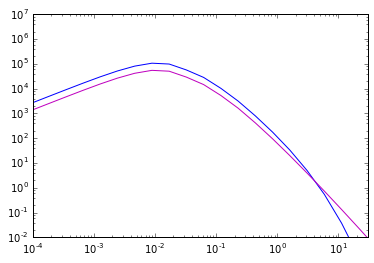

array([  1.39413604e+00,   1.39413604e+00,   1.39413604e+00,
         1.39413604e+00,   1.39413604e+00,   1.39413609e+00,
         1.39413627e+00,   1.39413690e+00,   1.39413906e+00,
         1.39414499e+00,   1.39415326e+00,   1.39415657e+00,
         1.39415739e+00,   1.39415784e+00,   1.39415442e+00,
         1.39414472e+00,   1.39410971e+00,   1.39397912e+00,
         1.39350255e+00,   1.39176165e+00,   1.38545995e+00,
         1.36337161e+00,   1.29378756e+00,   1.12771458e+00,
         8.60362127e-01,   5.31163076e-01,   2.57786208e-01,
         1.15207141e-01,   4.37958967e-02,   1.43155045e-02,
         4.17844391e-03,   1.19261194e-03,   3.27711777e-04,
         9.02681187e-05,   2.45735470e-05,   6.74477519e-06,
         1.81609721e-06,   5.00066564e-07,   1.37713955e-07,
         3.71995821e-08])

In [19]:
# Get the galaxy-galaxy 2-halo term

twoh_gg = np.zeros((len(k), len(z)))
for ki in range(0,len(k)):
    for zi in range(0,len(z)):
        twoh_gg[ki,zi] = scipy.integrate.simps(HMF[:,zi] * bh[:,zi] * y[ki, :] * N_tot, np.log10(Mhvec/(pa.HH0/100))) / nbar[zi]
       
P_2h_gg = Pklin* twoh_gg**2

# Integrate over z
P_2h_gg_avgz = np.zeros(len(k))
for ki in range(0,len(k)):
    P_2h_gg_avgz[ki] = scipy.integrate.simps(dNdz * P_2h_gg[ki,:], z)

plt.figure()
plt.loglog(k,P_2h_gg_avgz,  'b')
plt.hold(True)
plt.loglog(k, Pklin_avgz, 'm')
plt.xlim(0.0001,30)
plt.ylim(0.01, 10**7)
plt.show()

np.sqrt(P_2h_gg_avgz / Pklin_avgz)

In [ ]:
# Now use this to get the scale-dependent bias